1. Introduction

We are tasked with building a machine learning model to predict customer churn for Interconnect, a telecom company. The goal is to identify customers who are likely to leave, so the company can intervene with special offers or support.

Our target variable is based on the `EndDate` column — if `EndDate == 'No'`, the customer is still active.

The main metric to optimize is **AUC-ROC**, which helps us understand how well the model separates the churned vs. non-churned customers.


2. Data Loading and Initial Exploration

In [1]:
import pandas as pd

# Load all four datasets
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

# Quick look at the shape and first few rows of each
display(contract.head())
display(personal.head())
display(internet.head())
display(phone.head())


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


 3. Clarifying Questions

- Are we expected to balance the dataset manually, or should we keep it in its natural (likely imbalanced) form?  
- Should we prioritize reducing false negatives (missing potential churners), or is a general improvement of AUC-ROC the only concern?  
- Are we allowed to use ensemble models like XGBoost or CatBoost?  
- Should we consider merging the datasets on `customerID` and dropping it afterward?  
- Are there any features we should avoid using due to potential data leakage?  

4. Plan of Action

**Step 1: Data Preprocessing**  
Merge the datasets using the `customerID` key. Handle missing values, correct data types, and convert categorical variables where necessary. Encode the target variable based on `EndDate == 'No'`.

**Step 2: Exploratory Data Analysis (EDA)**  
Investigate feature distributions, identify potential outliers, and look for relationships between features and the target variable. This helps guide feature engineering.

**Step 3: Feature Engineering**  
Create or transform features to better capture patterns. For example, extract contract duration from start and end dates, or simplify service-related binary features.

**Step 4: Model Training and Evaluation**  
Split the data into training and validation sets. Train several models (logistic regression, random forest, etc.) and evaluate them using AUC-ROC and accuracy.

**Step 5: Final Model and Reporting**  
Choose the best-performing model and analyze its performance. Discuss feature importances and model limitations. Document everything clearly for handoff to stakeholders.

In [2]:
# Final Project - Interconnect Churn Prediction

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load datasets
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')


In [4]:
# Preview first few rows
display(contract.head())
display(personal.head())
display(internet.head())
display(phone.head())


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [5]:
# Check structure and missing values
print("Contract info:")
contract.info()
print("\nPersonal info:")
personal.info()
print("\nInternet info:")
internet.info()
print("\nPhone info:")
phone.info()


Contract info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

Personal info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner      

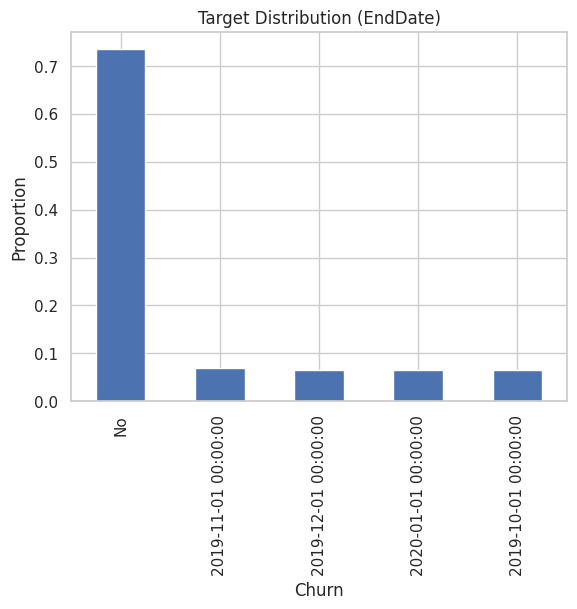

In [6]:
# Churn distribution
contract['EndDate'].value_counts(normalize=True).plot(kind='bar')
plt.title('Target Distribution (EndDate)')
plt.xlabel('Churn')
plt.ylabel('Proportion')
plt.show()


In [7]:
# Merge datasets on customerID
df = contract.merge(personal, on='customerID', how='left') \
             .merge(internet, on='customerID', how='left') \
             .merge(phone, on='customerID', how='left')

print("Combined data shape:", df.shape)
df.head()


Combined data shape: (7043, 20)


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


## Clarifying Questions

1. Should we treat missing values in service columns as "No" (not subscribed)?
2. Should we drop any columns considered identifiers (e.g., customerID)?
3. Are we expected to perform feature selection, or use all features?
4. Do we need to balance the dataset if churned customers are underrepresented?
5. Is there a specific accuracy threshold we should aim for, aside from AUC-ROC?

---

## Rough Work Plan

1. **Data Preparation:** Clean and merge all datasets. Handle missing values and encode categorical features properly.
2. **EDA:** Explore the target distribution and understand feature relationships. Identify potential outliers or biases.
3. **Feature Engineering:** Convert service features into usable numeric formats and engineer useful features if needed.
4. **Model Training:** Train classification models like Random Forest, Logistic Regression, or XGBoost. Use AUC-ROC as the main metric.
5. **Evaluation and Reporting:** Evaluate model performance on a validation set, summarize findings, and ensure reproducibility.



<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> Answers to questions: <br>
    1. Yes that is likely fair <br>
    2. Yes, they are not informative to the response. <br>
    3. That is up to personal discretion. <br>
    4. Again, that is up to you based on best praciitcs <br>
    5. No specific accuracy, we are really just aiming to maximize the AUC-ROC.
<a class="tocSkip"></a> 

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> This looks like a good plan! Best of luck.
<a class="tocSkip"></a>